<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

# _*Qiskit Aqua: Experiment with classification problem with quantum-enhanced support vector machines*_

The latest version of this notebook is available on https://github.com/qiskit/qiskit-tutorial.

### Contributors
Vojta Havrilek, Kristan Temme, Antonio Córcoles, Peng Liu, Richard Chen, Marco Pistoia and Jay Gambetta

### Introduction
Classification algorithms and methods for machine learning are essential for pattern recognition and data mining applications. Well known techniques such as support vector machines and neural networks have blossomed over the last two decades as a result of the spectacular advances in classical hardware computational capabilities and speed. This progress in computer power made it possible to apply techniques, that were theoretically developed towards the middle of the 20th century, on classification problems that were becoming increasingly challenging.

A key concept in classification methods is that of a kernel. Data cannot typically be separated by a hyperplane in its original space. A common technique used to find such a hyperplane consists on applying a non-linear transformation function to the data. This function is called a feature map, as it transforms the raw features, or measurable properties, of the phenomenon or subject under study. Classifying in this new feature space -and, as a matter of fact, also in any other space, including the raw original one- is nothing more than seeing how close data points are to each other. This is the same as computing the inner product for each pair of data in the set. So, in fact we do not need to compute the non-linear feature map for each datum, but only the inner product of each pair of data points in the new feature space. This collection of inner products is called the kernel and it is perfectly possible to have feature maps that are hard to compute but whose kernels are not.

In this notebook we provide an example of a classification problem that requires a feature map for which computing the kernel is not efficient classically -this means that the required computational resources are expected to scale exponentially with the size of the problem. We show how this can be solved in a quantum processor by a direct estimation of the kernel in the feature space. The method we used falls in the category of what is called supervised learning, consisting of a training phase (where the kernel is calculated and the support vectors obtained) and a test or classification phase (where new unlabelled data is classified according to the solution found in the training phase).

References and additional details:

[1] Vojtech Havlicek, Antonio D. C´orcoles, Kristan Temme, Aram W. Harrow, Abhinav Kandala, Jerry M. Chow, and Jay M. Gambetta1, "Supervised learning with quantum enhanced feature spaces," [arXiv: 1804.11326](https://arxiv.org/pdf/1804.11326.pdf)

In [1]:
from svm_datasets import *
from qiskit_acqua.svm.data_preprocess import *
from qiskit_acqua.input import get_input_instance
from qiskit_acqua import run_algorithm

import logging
logger = logging.getLogger()
# logger.setLevel(logging.DEBUG) # uncomment it to see detailed logging

In [2]:
################# import Qconfig and set APIToken and API url and  prepare backends ############
try:
    import sys
    sys.path.append("../../") # go to parent dir
    import Qconfig
except Exception as e:
    print(e)
    
from qiskit import register, available_backends

#set api
APItoken=getattr(Qconfig, 'APItoken', None)
url = Qconfig.config.get('url', None)
hub = Qconfig.config.get('hub', None)
group = Qconfig.config.get('group', None)
project = Qconfig.config.get('project', None)
try:
    register(APItoken, url, hub, group, project)
except Exception as e:
    print(e)

print("Backends: {}".format(available_backends()))

Backends: ['local_clifford_simulator', 'ibmqx2', 'ibmqx4', 'local_qasm_simulator', 'ibmqx5', 'local_unitary_simulator', 'ibmq_qasm_simulator', 'local_statevector_simulator']


First we prepare the dataset, which is used for training, testing and the finally prediction.

*Note: You can easily switch to a different dataset, such as the Breast Cancer dataset, by replacing 'ad_hoc_data' to 'Breast_cancer' below.*

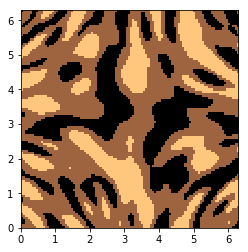

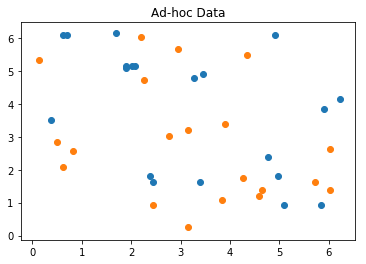

In [3]:
feature_dim=2 # we support feature_dim 2 or 3
sample_Total, training_input, test_input, class_labels = ad_hoc_data(training_size=20, test_size=10, n=feature_dim, gap=0.3, PLOT_DATA=True)
total_array, label_to_labelclass = get_points(test_input, class_labels)

With the dataset ready we initialize the necessary inputs for the algorithm:
- the input dictionary (params) 
- the input object containing the dataset info (algo_input).

In [4]:
params = {
    'problem': {'name': 'svm_classification'},
    'backend': {'name': 'local_qasm_simulator', 'shots':1000},
    'algorithm': {
        'name': 'SVM_QKernel',
        'print_info' : True
    }
}

algo_input = get_input_instance('SVMInput')
algo_input.training_dataset  = training_input
algo_input.test_dataset = test_input
algo_input.datapoints = total_array

With everything setup, we can now run the algorithm.

For the testing, the result includes the details and the success ratio.

For the prediction, the result includes the predicted labels. 

In [5]:
result = run_algorithm(params,algo_input)
print("testing success ratio: ", result['test_success_ratio'])
print("predicted labels:", result['predicted_labels'])


classifying [0.18849556 3.45575192]
Label should be  A
Predicted label is  A
CORRECT

classifying [3.20442451 5.78053048]
Label should be  A
Predicted label is  A
CORRECT

classifying [1.82212374 4.1469023 ]
Label should be  A
Predicted label is  A
CORRECT

classifying [3.45575192 4.77522083]
Label should be  A
Predicted label is  A
CORRECT

classifying [5.46637122 4.90088454]
Label should be  A
Predicted label is  A
CORRECT

classifying [5.59203492 1.88495559]
Label should be  A
Predicted label is  A
CORRECT

classifying [2.07345115 2.07345115]
Label should be  A
Predicted label is  A
CORRECT

classifying [4.71238898 5.90619419]
Label should be  A
Predicted label is  A
CORRECT

classifying [4.90088454 5.96902604]
Label should be  A
Predicted label is  A
CORRECT

classifying [0.62831853 5.46637122]
Label should be  A
Predicted label is  A
CORRECT

classifying [0.         5.40353936]
Label should be  B
Predicted label is  B
CORRECT

classifying [1.25663706 2.95309709]
Label should be  

kernel matrix of the training data:


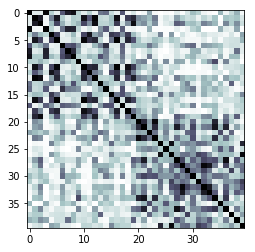

In [6]:
print("kernel matrix of the training data:")
kernel_matrix = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_matrix),interpolation='nearest',origin='upper',cmap='bone_r')
plt.show()

### The breast cancer dataset
Now we run our algorithm with the real-world dataset: the breast cancer dataset, we use the first two principal componenets as features.

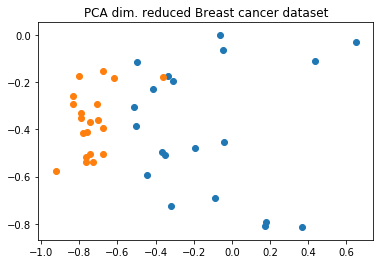

In [7]:
sample_Total, training_input, test_input, class_labels = Breast_cancer(training_size=20, test_size=10, n=feature_dim, PLOT_DATA=True)

In [8]:
algo_input = get_input_instance('SVMInput')
algo_input.training_dataset  = training_input
algo_input.test_dataset = test_input
algo_input.datapoints = total_array
result = run_algorithm(params, algo_input)

print("testing success ratio: ", result['test_success_ratio'])
print("predicted labels:", result['predicted_labels'])


classifying [-0.19145523 -0.40049514]
Label should be  A
Predicted label is  A
CORRECT

classifying [ 0.00296749 -0.94935632]
Label should be  A
Predicted label is  A
CORRECT

classifying [-0.05159529 -0.58740841]
Label should be  A
Predicted label is  A
CORRECT

classifying [ 1. -1.]
Label should be  A
Predicted label is  A
CORRECT

classifying [-0.02042312  0.08955068]
Label should be  A
Predicted label is  A
CORRECT

classifying [ 0.11392697 -0.88419484]
Label should be  A
Predicted label is  B
INCORRECT

classifying [-0.37623563 -0.28188762]
Label should be  A
Predicted label is  B
INCORRECT

classifying [-0.39911714 -0.22268894]
Label should be  A
Predicted label is  A
CORRECT

classifying [-0.23286086 -0.68622751]
Label should be  A
Predicted label is  A
CORRECT

classifying [-0.30860543 -0.65487001]
Label should be  A
Predicted label is  A
CORRECT

classifying [-0.85747047 -0.4786827 ]
Label should be  B
Predicted label is  B
CORRECT

classifying [-0.72689282 -0.57851403]
Label

kernel matrix of the training data:


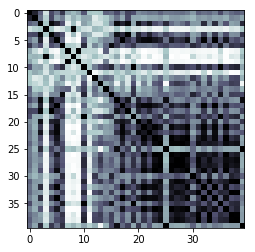

In [9]:
print("kernel matrix of the training data:")
kernel_matrix = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_matrix),interpolation='nearest',origin='upper',cmap='bone_r')
plt.show()